# 全球各国新型冠状病毒确诊病例动态排序图制作

## 思路 

1. 从数据源提取有用数据
2. 从有用数据中提取出一天的数据，按照国家分组求和
3. 根据每天各国确诊病例数画出柱形图
4. 使用 matplotlib.animation 将每天的柱形图绘制成动画

In [1]:
# 导入库文件
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
#防止动漫内存太大，报错
matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [2]:
#导入random函数，random_color用于生成颜色代码
# random_color生成颜色代码原理，
# 【1-9/A-F】15个数字随机组合成6位字符串前面再加上一个“#”号键
import random
def random_color():
    cl = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color =''
    for i in range(6):
        color += random.choice(cl)
    return '#'+ color

## 获取原始数据 

In [3]:
df = pd.read_csv('../source_data.csv')
df

,Unnamed: 0,date,country,countryCode,province,provinceCode,city,cityCode,confirmed,suspected,cured,dead
0,0,2019-12-01,中国,CN,NaN,NaN,NaN,NaN,1,0,0,0
1,1,2019-12-01,中国,CN,湖北省,420000.0,NaN,NaN,1,0,0,0
2,2,2019-12-01,中国,CN,湖北省,420000.0,武汉市,420100,1,0,0,0
3,3,2019-12-02,中国,CN,NaN,NaN,NaN,NaN,1,0,0,0
4,4,2019-12-02,中国,CN,湖北省,420000.0,NaN,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43126,43126,2020-04-05,马约特,YT,NaN,NaN,NaN,NaN,128,0,0,2
43127,43127,2020-04-05,南非,ZA,NaN,NaN,NaN,NaN,1505,0,95,9
43128,43128,2020-04-05,赞比亚,ZM,NaN,NaN,NaN,NaN,39,0,2,1
43129,43129,2020-04-05,津巴布韦,ZW,NaN,NaN,NaN,NaN,9,0,0,1


## 提取有用数据

In [4]:
#筛选出日期、国家、确诊数
df1 = pd.read_csv('../source_data.csv', usecols=['date', 'country', 'confirmed'])
df1

,date,country,confirmed
0,2019-12-01,中国,1
1,2019-12-01,中国,1
2,2019-12-01,中国,1
3,2019-12-02,中国,1
4,2019-12-02,中国,1
...,...,...,...
43126,2020-04-05,马约特,128
43127,2020-04-05,南非,1505
43128,2020-04-05,赞比亚,39
43129,2020-04-05,津巴布韦,9


### 获取某一天各国确诊病例数

In [5]:
#同一日期的国家和确诊数
current_date = '2020-04-05'
df2 = df1[df1['date'].eq(current_date)]
df2

,date,country,confirmed
42390,2020-04-05,钻石公主号邮轮,712
42391,2020-04-05,波黑,617
42392,2020-04-05,格恩西岛,91
42393,2020-04-05,泽西岛,81
42394,2020-04-05,英国属地曼岛,71
...,...,...,...
43126,2020-04-05,马约特,128
43127,2020-04-05,南非,1505
43128,2020-04-05,赞比亚,39
43129,2020-04-05,津巴布韦,9


### 对当天国家确诊病例数汇总

In [6]:
#一天一个国家的确诊数
#因为原始数据中，中国分省市并且还有中国全国的汇总确诊数并放在中国分组的第一行，所以取分组第一行数据
df3 = df2.groupby(by=['country']).head(1)
df3

,date,country,confirmed
42390,2020-04-05,钻石公主号邮轮,712
42391,2020-04-05,波黑,617
42392,2020-04-05,格恩西岛,91
42393,2020-04-05,泽西岛,81
42394,2020-04-05,英国属地曼岛,71
...,...,...,...
43126,2020-04-05,马约特,128
43127,2020-04-05,南非,1505
43128,2020-04-05,赞比亚,39
43129,2020-04-05,津巴布韦,9


In [7]:
df4 = df3.sort_values(by='confirmed', ascending=True).tail(10)
df4

,date,country,confirmed
42435,2020-04-05,瑞士,20278
43112,2020-04-05,土耳其,23934
42999,2020-04-05,英国,42449
43024,2020-04-05,伊朗,55743
42439,2020-04-05,中国,82930
42997,2020-04-05,法国,90842
42982,2020-04-05,德国,96621
43026,2020-04-05,意大利,124632
42992,2020-04-05,西班牙,126168
43117,2020-04-05,美国,308850


### 制作国家-颜色映射表

In [8]:
#生成字典: {国家: 颜色}
country_list = set(df1['country'])
color_list = []
for i in range(len(country_list)):
    color_list.append(random_color())

colors = dict(zip(country_list, color_list))
#colors

### 画出当天全球确诊病例排序图

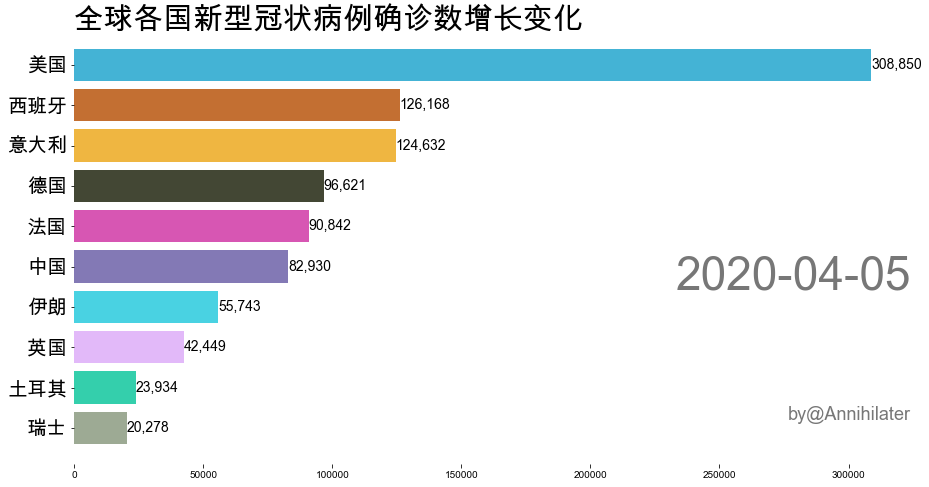

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.clear()
country_list = df4.index.to_list()
ax.barh(df4['country'], df4['confirmed'], color=[colors[x] for x in df4['country']])
for i, (name, value) in enumerate(zip(df4['country'], df4['confirmed'])):
    ax.text(value,i ,f'{value:,.0f}',size=14,ha='left',va ='center')

#设置标题
ax.text(0,1.05,'全球各国新型冠状病例确诊数增长变化',transform=ax.transAxes,size=30,weight=600,ha='left',va='top')

#设置作者
ax.text(1,0.1,'by@Annihilater',transform = ax.transAxes,color ='#777777',size=18,ha ='right',bbox=dict(facecolor='white',alpha = 0.8,edgecolor='white'))

#画布右中添加年份
ax.text(1,0.4,current_date,transform = ax.transAxes,color ='#777777',size = 46,ha ='right',weight=800) 

plt.yticks(fontsize=20)
plt.box(False)

将以上数据提取写成函数

In [10]:
def gen_data(current_date):
    df2 = df1[df1['date'].eq(current_date)]
    df3 = df2.groupby(by=['country']).head(1)
    df4 = df3.sort_values(by='confirmed', ascending=True).tail(10)
    return df4
gen_data(current_date)

,date,country,confirmed
42435,2020-04-05,瑞士,20278
43112,2020-04-05,土耳其,23934
42999,2020-04-05,英国,42449
43024,2020-04-05,伊朗,55743
42439,2020-04-05,中国,82930
42997,2020-04-05,法国,90842
42982,2020-04-05,德国,96621
43026,2020-04-05,意大利,124632
42992,2020-04-05,西班牙,126168
43117,2020-04-05,美国,308850


画出一天的全球各国确诊病例排序图写成函数

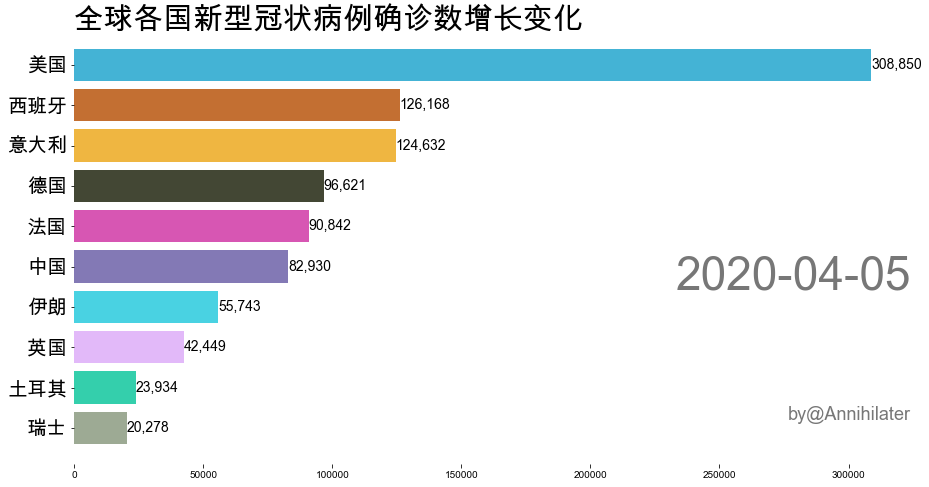

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
def draw_bar_chart(current_date):
    df5 = gen_data(current_date)
    ax.clear()
    ax.barh(df5['country'], df5['confirmed'], color=[colors[x] for x in df5['country']])
    for i, (name, value) in enumerate(zip(df5['country'], df5['confirmed'])):
        ax.text(value,i ,f'{value:,.0f}',size=14,ha='left',va ='center')
    #设置标题
    ax.text(0,1.05,'全球各国新型冠状病例确诊数增长变化',transform=ax.transAxes,size=30,weight=600,ha='left',va='top')
    #设置作者
    ax.text(1,0.1,'by@Annihilater',transform = ax.transAxes,color ='#777777',size=18,ha ='right',bbox=dict(facecolor='white',alpha = 0.8,edgecolor='white'))
    #画布右中添加年份
    ax.text(1,0.4,current_date,transform = ax.transAxes,color ='#777777',size = 46,ha ='right',weight=800) 
    
    plt.yticks(fontsize=20)
    plt.box(False)
draw_bar_chart(current_date)

## 绘制动画

In [12]:
date_list = list(set(df['date']))
date_list.sort()
#date_list

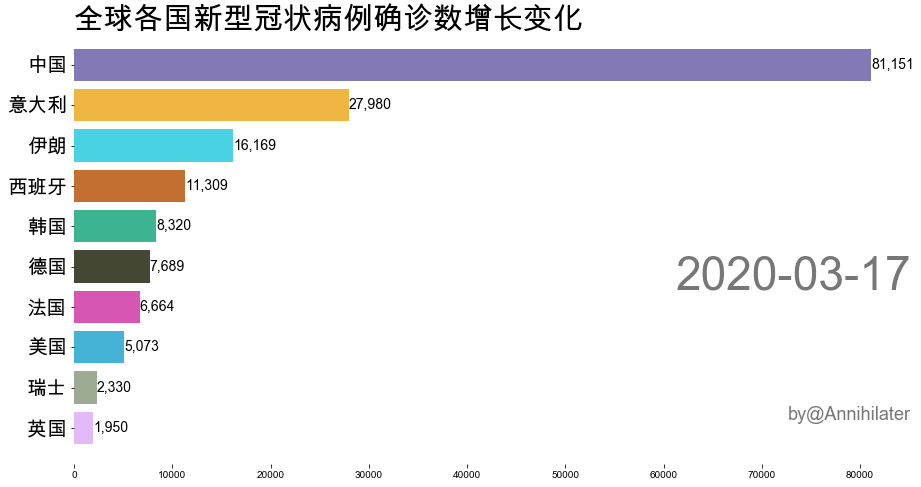

In [13]:
#将原来的静态图拼接成动画
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_bar_chart, frames=date_list[-20:])#保存到jshtml
HTML(animator.to_jshtml())

## 保存动画

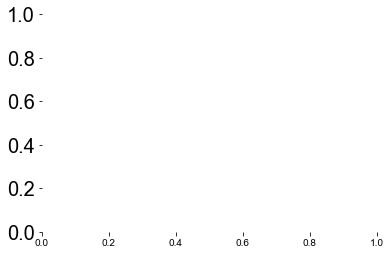

In [14]:
#生成video，并保存至指定文件夹中
animator.to_html5_video()
animator.save('global_coronavirus_numbers.mp4')